In [1]:
import json
import os
import contextlib
import warnings
warnings.filterwarnings(action='ignore')

from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd

from tabulate import tabulate
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import ultralytics.utils.metrics as umetrics
import torch

## functions

In [2]:
def get_gt(gt_path, agnostic=False):
    gt = json.load(open(gt_path))
    unique_ids = sorted(list(set([x['id'] for x in gt['images']])))
    
    gt_objects = []
    for img_id in unique_ids:
        img_annos = [x for x in gt['annotations'] if x['image_id']==img_id]

        img_bboxes = []

        for img_anno in img_annos:
            xmin,ymin,w,h = img_anno['bbox']
            xmax,ymax = xmin+w, ymin+h
            cls = img_anno['category_id']  if not agnostic else 0
            img_bboxes.append([xmin,ymin,xmax,ymax,cls])
        gt_objects.append(img_bboxes)
        
    nc = len(gt['categories']) if not agnostic else 1
    return gt_objects, unique_ids, nc

def get_stats(gt_objects, unique_ids, nc, res_path, conf=0.1, iou_thres=0.5, agnostic=False):
    pred = json.load(open(res_path))
    pred_objects = []
    for img_id in unique_ids:
        img_annos = [x for x in pred if x['image_id']==img_id]

        img_bboxes = []

        for img_anno in img_annos:
            xmin,ymin,w,h = img_anno['bbox']
            xmax,ymax = xmin+w, ymin+h
            cls = img_anno['category_id'] if not agnostic else 0
            score = img_anno['score']
            img_bboxes.append([xmin,ymin,xmax,ymax,score,cls])
        pred_objects.append(img_bboxes)
    assert len(pred_objects)==len(gt_objects)
    
    CM = umetrics.ConfusionMatrix(nc, conf, iou_thres)
    for i in range(len(gt_objects)):

        img_gt = torch.tensor(gt_objects[i])
        img_pred = torch.tensor(pred_objects[i])
        if not img_pred.numel():
            img_pred = torch.empty((0,6))

        if img_gt.numel():
            gt_bboxes = img_gt[:, :-1]
            gt_cls = img_gt[:,-1]
        else:
            gt_bboxes = torch.empty((0,4))
            gt_cls = torch.empty((0))

        CM.process_batch(img_pred, gt_bboxes, gt_cls)

    tp, fp, fn = CM.tp_fp_fn()    
    tp, fp, fn = tp.sum(), fp.sum(), fn.sum()
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f1 = 2*(p*r)/(p+r)
    
    return tp,fp,fn,p,r,f1
    

In [3]:
def get_metrics_df(det_paths, gt_path, iou_th, max_dets, names, conf=0.1, iou_thres=0.5):
#     def get_pr(all_params):
#         recall_all = all_params['recall'][0,:,:,-1] # iou_th=0.5, max max_dets
#         mean_recall = np.mean(recall_all[recall_all>-1])

#         precision_all = all_params['precision'][0,:,:,:,-1] # iou_th=0.5, max max_dets
#         rec_ind = [[i, x] for i,x in enumerate(all_params['params'].recThrs) if x==round(mean_recall, 2)]
#         rec_ind, rec_val = rec_ind[0]

#         p = precision_all[rec_ind,:,:]
#         p = np.mean(p[p>-1])
#         return p, mean_recall
    
    
    gt_objects, unique_ids, nc = get_gt(gt_path)
    all_metrics = []
    for det_path in tqdm(det_paths):

        det = json.load(open(det_path))
        # print(len(det))
        det = [x for x in det if x['score'] >= th] if th is not None else det
        # print(len(det))
        # print(max_dets, iou_th)

        th_path = det_path.replace('.json', f'-mapped.json')
        with open(th_path, 'w', encoding='utf-8') as f:
            json.dump(det, f, ensure_ascii=False, indent=4)

        method, ds = os.path.dirname(det_path).split(os.sep)[-2:]
        method = ds.split('-')[1]
        th = ds.split('-')[-1].replace('th0', '0.')
        # print(method, ds)
        
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            anno = COCO(gt_path)
            pred = anno.loadRes(th_path)  # init predictions api
            eval = COCOeval(anno, pred, 'bbox', iouThr=iou_th, maxDets=max_dets)
            imgIds = sorted(anno.getImgIds())
            eval.params.imgIds = imgIds


            eval.evaluate()
            eval.accumulate()
            eval.summarize()
            map, map50 = eval.stats[:2]
            all_params = eval.eval
            # p,r = get_pr(all_params)
            tp,fp,fn,p,r,f1 = get_stats(gt_objects, unique_ids, nc, th_path, conf=conf, iou_thres=iou_thres)

        stats = {k:v for k,v in zip(names+['TP', 'FP', 'FN', 'P','R', 'F1'], [method, ds] + [x*100 for x in eval.stats.tolist()]+[tp,fp,fn]+[_*100 for _ in [p,r,f1]])}
        all_metrics.append(stats)

    metrics = pd.DataFrame(all_metrics)
    return metrics

## constants

In [130]:
th = 0.01 #0.2 #0.01

sds_gt = 'data/SeaDronesSee/test_dev.json'
names_sds = ['method', 'dataset', 'AP', 'AP50', 'AP75', 'APu', 'APvt', 'APt', 'APs', 'APm', 'APl', 'AR1', 'AR10', 'AR100', 'ARu', 'ARvt', 'ARt', 'ARs', 'ARm', 'ARl']
max_dets_sds = [1,10,100]
iou_th_sds = None

dc_gt = 'data/DroneCrowd/test_minus_val.json'
names_dc = ['method', 'dataset', 'AP', 'AP50', 'AP75', 'APu', 'APvt', 'APt', 'APs', 'APm', 'APl', 'AR500', 'ARu', 'ARvt', 'ARt', 'ARs', 'ARm', 'ARl']
max_dets_dc = [500]
iou_th_dc = 0.5

## &#x2705; SEG_RESOLUTION vs tracker outcome 

In [10]:
sds = sorted(glob('/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/SEG-RES/**/results-test_dev.json', recursive=True))
print(sds, len(sds))
sds_csv = 'ablation/SDS-seg-res.csv'

['/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/SEG-RES/SDS-roi-large/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/SEG-RES/SDS-roi-medium/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/SEG-RES/SDS-roi-small/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/SEG-RES/SDS-roi-tiny/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/SEG-RES/SDS-roi_track-large/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/SEG-RES/SDS-roi_track-medium/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/SEG-RES/SDS-roi_track-small/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/SEG-RES/SDS-roi_track-tiny/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/SEG-RES/SDS-roi_track_bintrk-large/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablatio

In [212]:
m = []

gt_objects, unique_ids, nc = get_gt(sds_gt, agnostic=False)

for det_path in tqdm(sds):
    method, ds = os.path.dirname(det_path).split(os.sep)[-2:]
    tp,fp,fn,p,r,f1 = get_stats(gt_objects, unique_ids, nc, det_path, conf=0.1, iou_thres=0.5, agnostic=False)
    m.append({
        'method': method,
        'ds': ds,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'P': p*100,
        'R': r*100,
        'F1': f1*100
    })
    
metrics_cls = pd.DataFrame(m)
metrics_cls.to_csv('ablation/SDS-seg-res-basic.csv')
metrics_cls

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [16:29<00:00, 70.65s/it]


,method,ds,TP,FP,FN,P,R,F1
0,SEG-RES,SDS-roi-large,41845.0,9765.0,5833.0,81.079248,87.765846,84.290146
1,SEG-RES,SDS-roi-medium,41850.0,9790.0,5828.0,81.041828,87.776333,84.274754
2,SEG-RES,SDS-roi-small,39025.0,7883.0,8653.0,83.194764,81.851168,82.517497
3,SEG-RES,SDS-roi-tiny,31367.0,4985.0,16311.0,86.286862,65.789253,74.656670
4,SEG-RES,SDS-roi_track-large,42201.0,10967.0,5477.0,79.372931,88.512521,83.693949
5,SEG-RES,SDS-roi_track-medium,42016.0,11276.0,5662.0,78.841102,88.124502,83.224720
6,SEG-RES,SDS-roi_track-small,41406.0,9904.0,6272.0,80.697720,86.845086,83.658625
7,SEG-RES,SDS-roi_track-tiny,40002.0,8796.0,7676.0,81.974671,83.900331,82.926324
8,SEG-RES,SDS-roi_track_bintrk-large,42214.0,10272.0,5464.0,80.429067,88.539788,84.289765
9,SEG-RES,SDS-roi_track_bintrk-medium,42207.0,10238.0,5471.0,80.478597,88.525106,84.310298


In [11]:
# metrics_sds_roi_size = get_metrics_df(sds, sds_gt, iou_th_sds, max_dets_sds, names_sds, conf=0.1, iou_thres=0.5)
# metrics_sds_roi_size.to_csv(sds_csv, index=False)
metrics_sds_roi_size = pd.read_csv(sds_csv)
metrics_sds_roi_size

,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,SEG-RES,SDS-roi-large,50.574389,83.390200,54.283053,-100.0,33.109244,47.661440,58.781213,38.313543,...,59.290419,66.747107,44.556447,63.955550,41845.0,9765.0,5833.0,81.079248,87.765846,84.290146
1,SEG-RES,SDS-roi-medium,50.660284,83.197517,54.369686,-100.0,34.569236,47.365620,59.452470,38.101579,...,57.951482,66.758314,44.039685,66.700064,41850.0,9790.0,5828.0,81.041828,87.776333,84.274754
2,SEG-RES,SDS-roi-small,47.236878,76.023740,51.361165,-100.0,24.527248,43.690880,60.181650,38.773203,...,53.643089,67.023428,43.916678,70.290633,39025.0,7883.0,8653.0,83.194764,81.851168,82.517497
3,SEG-RES,SDS-roi-tiny,38.062768,59.601752,41.561434,-100.0,10.356607,30.632313,59.714309,36.148309,...,37.251770,66.013101,40.530851,70.746859,31367.0,4985.0,16311.0,86.286862,65.789253,74.656670
4,SEG-RES,SDS-roi_track-large,50.262606,83.660235,53.684276,-100.0,35.583414,47.393074,58.508476,35.729556,...,59.673971,66.651019,42.706817,54.699626,42201.0,10967.0,5477.0,79.372931,88.512521,83.693949
5,SEG-RES,SDS-roi_track-medium,50.604422,83.430181,54.490949,-100.0,35.225827,47.605368,59.161656,35.917936,...,59.687725,66.600964,42.226580,58.337508,42016.0,11276.0,5662.0,78.841102,88.124502,83.224720
6,SEG-RES,SDS-roi_track-small,49.812678,81.762503,53.769187,-100.0,34.064308,45.479757,59.494715,36.706700,...,57.346226,66.560764,42.447600,61.014830,41406.0,9904.0,6272.0,80.697720,86.845086,83.658625
7,SEG-RES,SDS-roi_track-tiny,48.640029,78.941984,52.836494,-100.0,28.142612,44.332099,59.861395,36.158549,...,56.376180,66.606849,41.623197,63.967677,40002.0,8796.0,7676.0,81.974671,83.900331,82.926324
8,SEG-RES,SDS-roi_track_bintrk-large,50.853692,84.260094,54.352871,-100.0,35.432676,47.563658,58.740806,38.109756,...,59.423977,66.788740,43.908420,67.295245,42214.0,10272.0,5464.0,80.429067,88.539788,84.289765
9,SEG-RES,SDS-roi_track_bintrk-medium,51.116020,84.322917,54.558613,-100.0,34.996998,48.331997,59.404534,37.874706,...,59.382263,66.828857,43.378961,67.749682,42207.0,10238.0,5471.0,80.478597,88.525106,84.310298


In [12]:
metrics_sds_roi_size['method'] = metrics_sds_roi_size.apply(lambda x: x.dataset.split('-')[1], axis=1)
metrics_sds_roi_size['dataset'] = metrics_sds_roi_size.apply(lambda x: x.dataset.split('-')[-1], axis=1)
metrics_sds_roi_size = metrics_sds_roi_size.rename(columns={'dataset': 'input size'})
metrics_sds_roi_size['input size'] = metrics_sds_roi_size['input size'].replace({'tiny': '64x96', 'small': '128x192', 'medium': '224x384', 'large': '448x768'})

metrics_roi = metrics_sds_roi_size[metrics_sds_roi_size.method=='roi'][[x for x in metrics_sds_roi_size.columns if x != 'method']]
metrics_roi = metrics_roi.sort_values(by='input size', key = lambda col: [int(x.split('x')[0]) for x in col])
metrics_roi_track = metrics_sds_roi_size[metrics_sds_roi_size.method=='roi_track_bintrk'][[x for x in metrics_sds_roi_size.columns if x != 'method']]
metrics_roi_track = metrics_roi_track.sort_values(by='input size', key = lambda col: [int(x.split('x')[0]) for x in col])

metrics_roi

,input size,AP,AP50,AP75,APu,APvt,APt,APs,APm,APl,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
3,64x96,38.062768,59.601752,41.561434,-100.0,10.356607,30.632313,59.714309,36.148309,63.771530,...,37.251770,66.013101,40.530851,70.746859,31367.0,4985.0,16311.0,86.286862,65.789253,74.656670
2,128x192,47.236878,76.023740,51.361165,-100.0,24.527248,43.690880,60.181650,38.773203,65.183429,...,53.643089,67.023428,43.916678,70.290633,39025.0,7883.0,8653.0,83.194764,81.851168,82.517497
1,224x384,50.660284,83.197517,54.369686,-100.0,34.569236,47.365620,59.452470,38.101579,63.054105,...,57.951482,66.758314,44.039685,66.700064,41850.0,9790.0,5828.0,81.041828,87.776333,84.274754
0,448x768,50.574389,83.390200,54.283053,-100.0,33.109244,47.661440,58.781213,38.313543,61.419307,...,59.290419,66.747107,44.556447,63.955550,41845.0,9765.0,5833.0,81.079248,87.765846,84.290146


In [13]:
metrics_roi_track

,input size,AP,AP50,AP75,APu,APvt,APt,APs,APm,APl,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
11,64x96,48.218176,77.482743,52.496244,-100.0,25.995918,44.454804,59.831521,37.648284,62.944379,...,54.532581,66.471935,42.363876,70.746859,39192.0,6921.0,8486.0,84.991217,82.201435,83.573051
10,128x192,50.535369,82.395952,54.601561,-100.0,33.839651,46.562280,60.064747,38.756527,64.444521,...,57.146604,66.970387,43.731009,70.615060,41564.0,8588.0,6114.0,82.876057,87.176476,84.971890
9,224x384,51.116020,84.322917,54.558613,-100.0,34.996998,48.331997,59.404534,37.874706,64.014560,...,59.382263,66.828857,43.378961,67.749682,42207.0,10238.0,5471.0,80.478597,88.525106,84.310298
8,448x768,50.853692,84.260094,54.352871,-100.0,35.432676,47.563658,58.740806,38.109756,63.946016,...,59.423977,66.788740,43.908420,67.295245,42214.0,10272.0,5464.0,80.429067,88.539788,84.289765


In [14]:
fps = pd.read_csv('ablation/seg-res-FPS.csv')
fps

,model,time-SEG,time-track,time-sum,FPS-SEG,FPS-TRACK,FPS-SUM
0,64x96,0.002360,0.000578,0.002938,423.728814,1731.175121,340.409040
1,128x192,0.002650,0.000640,0.003290,377.358491,1563.517248,303.989842
2,224x384,0.005111,0.000779,0.005890,195.656427,1284.262327,169.789171
3,448x768,0.012169,0.000728,0.012897,82.176021,1373.261875,77.536250


In [15]:
times = {}

for i in range(len(fps)):
    fps_ = fps.iloc[i]
    times[fps_['model']] = f"SEG {int(fps_['FPS-SEG'])} FPS\nSEG+TRACK {int(fps_['FPS-SUM'])} FPS"
times

{'64x96': 'SEG 423 FPS\nSEG+TRACK 340 FPS',
 '128x192': 'SEG 377 FPS\nSEG+TRACK 303 FPS',
 '224x384': 'SEG 195 FPS\nSEG+TRACK 169 FPS',
 '448x768': 'SEG 82 FPS\nSEG+TRACK 77 FPS'}

In [16]:
diff = metrics_roi_track.set_index(['input size']).subtract(metrics_roi.set_index(['input size']), fill_value=0)
diff = diff.reset_index()
diff

,input size,AP,AP50,AP75,APu,APvt,APt,APs,APm,APl,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,64x96,10.155408,17.880991,10.934810,0.0,15.639311,13.822491,0.117212,1.499974,-0.827151,...,17.280812,0.458834,1.833025,0.000000,7825.0,1936.0,-7825.0,-1.295645,16.412182,8.916380
1,128x192,3.298491,6.372212,3.240397,0.0,9.312404,2.871400,-0.116903,-0.016675,-0.738908,...,3.503515,-0.053041,-0.185668,0.324427,2539.0,705.0,-2539.0,-0.318707,5.325307,2.454393
2,224x384,0.455736,1.125400,0.188928,0.0,0.427762,0.966377,-0.047935,-0.226872,0.960455,...,1.430781,0.070543,-0.660724,1.049618,357.0,448.0,-357.0,-0.563231,0.748773,0.035545
3,448x768,0.279304,0.869894,0.069818,0.0,2.323432,-0.097782,-0.040407,-0.203787,2.526709,...,0.133558,0.041633,-0.648028,3.339695,369.0,507.0,-369.0,-0.650181,0.773942,-0.000381


In [16]:
table_header = ['size', 'APs', 'APst', 'AR10s', 'AR10st', 'FPSs', 'FPSst']

rows = []

for i in range(len(diff)):
    s = metrics_roi.iloc[i]
    st = metrics_roi_track.iloc[i]
    d = diff.iloc[i]
    
    size = d['input size']
    aps, apst, apd = s.AP, st.AP, d.AP
    ars, arst, ard = s.AR10, st.AR10, d.AR10
    print(size, aps, apst, apd, ars, arst, ard)
    
    fpss, fpsst = int(fps.iloc[i]['FPS-SEG']), int(fps.iloc[i]['FPS-SUM'])
    fpsd = fpsst-fpss
    
    rows.append([
        size,
        f'{aps:.1f}',
        f'{apst:.1f} (+{apd:.1f})',
        f'{ars:.1f}',
        f'{arst:.1f} (+{ard:.1f})',
        f'{fpss}',
        f'{fpsst} ({fpsd})',
        
    ])

open('../../tables/seg-size.tex', 'w').write(tabulate(rows, table_header, tablefmt='latex', stralign='center', numalign='left', floatfmt=".1f"))
print(tabulate(rows, table_header)) #, tablefmt='latex', stralign='center', numalign='left', floatfmt=".1f")

64x96 38.06276750641179 48.218175866396415 10.155408359984627 42.94437447706102 55.40871429046384 12.464339813402823
128x192 47.23687781736185 50.5353686867098 3.298490869347951 54.44307569788304 58.412801734737904 3.9697260368548655
224x384 50.660284426557 51.11602033220638 0.4557359056493837 58.82547999552036 59.59276673824105 0.7672867427206924
448x768 50.57438866570555 50.85369249730742 0.27930383160187233 59.45826316428698 59.66409243035434 0.2058292660673544
size       APs  APst            AR10s  AR10st          FPSs  FPSst
-------  -----  ------------  -------  ------------  ------  ---------
64x96     38.1  48.2 (+10.2)     42.9  55.4 (+12.5)     423  340 (-83)
128x192   47.2  50.5 (+3.3)      54.4  58.4 (+4.0)      377  303 (-74)
224x384   50.7  51.1 (+0.5)      58.8  59.6 (+0.8)      195  169 (-26)
448x768   50.6  50.9 (+0.3)      59.5  59.7 (+0.2)       82  77 (-5)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

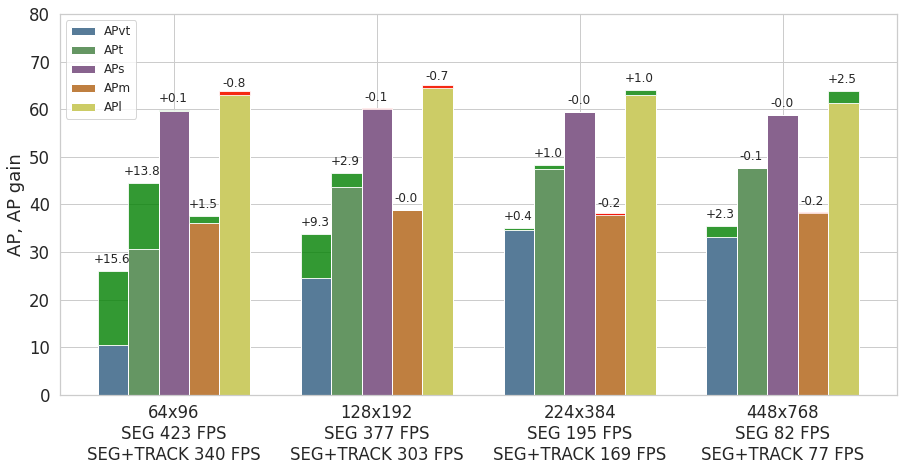

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

models = ['64x96', '128x192', '224x384', '448x768']
aps = ['APvt', 'APt', 'APs', 'APm', 'APl'] #, 'AP', 'AP50', 'AP75'] #[x for x in diff.columns if 'AP' in x and 'APu' not in x]
ars = ['ARvt', 'ARt', 'ARs', 'ARm', 'ARl'] #, 'AR10'] #[x for x in diff.columns if 'AR' in x and 'ARu' not in x and x!='AR1' and x!='AR100']


sns.set(style = 'whitegrid', font_scale = 1.5)
palette = sns.color_palette("Set1", n_colors=9, desat=0.5)
palette = palette[1:]
sns.set_palette(palette)

# sns.set_palette(sns.color_palette("Set1", desat=0.5))

plt.tight_layout()
plt.figure(figsize=(15,7))
ax  = plt.gca()

N = len(models)
ind = np.arange(N)  # the x locations for the groups
width = 0.15  # the width of the bars


rects_base = []
for I, ap_name in enumerate(aps):
    roi_values = metrics_roi[ap_name].values
    roi_track_values = metrics_roi_track[ap_name].values
    diff_values = diff[ap_name].values
    
    bottoms, values, colors = [], [], []
    for d, diff_value in enumerate(diff_values):
        if diff_value < 0:
            bottom = roi_track_values[d]
            value = abs(diff_value)
            color = 'red'
        else:
            bottom = roi_values[d]
            value = diff_value
            color = 'green'
        bottoms.append(bottom); values.append(value); colors.append(color)

    rect_base = plt.bar(ind+I*width, roi_values, width)
    rects_base.append(rect_base)
    
    for i, rect in enumerate(rect_base):
        r = plt.bar(x = rect.xy[0]+0.5*width, height=values[i], width=width, bottom=bottoms[i], color=colors[i], alpha=0.8)
        
        x = rect.xy[0]+0.5*width-0.005
        y = roi_track_values[i] + 2
        text = f'{diff_values[i]:.1f}' if diff_values[i] < 0 else f'+{diff_values[i]:.1f}'
        ax.annotate(text, (x,y), ha='center',
                va='center',
                xytext=(0, 2),
                textcoords='offset points', fontsize=12)


# plt.xlabel('model input size')
plt.ylabel('AP, AP gain')
plt.ylim([0,80])

xticks = [f'{model}\n{times[model]}' for model in models]

plt.xticks(ind + 2*width, xticks, rotation=0)
_ = plt.legend( [rect[0] for rect in rects_base], aps, loc='upper left', fontsize=12)
plt.savefig('../../plots/SDS-seg-res-bin-trk.png',bbox_inches='tight', pad_inches=0)
plt.savefig('../../plots/SDS-seg-res-bin-trk.eps',bbox_inches='tight', pad_inches=0)

In [60]:
diff

,input size,AP,AP50,AP75,APu,APvt,APt,APs,APm,APl,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,64x96,10.155408,17.880991,10.934810,0.0,15.639311,13.822491,0.117212,1.499974,-0.827151,...,17.280812,0.458834,1.833025,0.000000,7825.0,1936.0,-7825.0,-1.295645,16.412182,8.916380
1,128x192,3.298491,6.372212,3.240397,0.0,9.312404,2.871400,-0.116903,-0.016675,-0.738908,...,3.503515,-0.053041,-0.185668,0.324427,2539.0,705.0,-2539.0,-0.318707,5.325307,2.454393
2,224x384,0.455736,1.125400,0.188928,0.0,0.427762,0.966377,-0.047935,-0.226872,0.960455,...,1.430781,0.070543,-0.660724,1.049618,357.0,448.0,-357.0,-0.563231,0.748773,0.035545
3,448x768,0.279304,0.869894,0.069818,0.0,2.323432,-0.097782,-0.040407,-0.203787,2.526709,...,0.133558,0.041633,-0.648028,3.339695,369.0,507.0,-369.0,-0.650181,0.773942,-0.000381


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

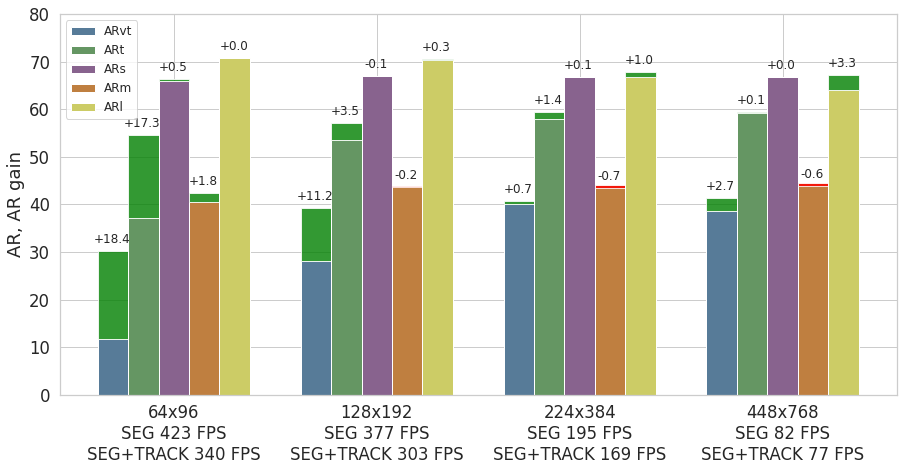

In [83]:
sns.set(style = 'whitegrid', font_scale = 1.5)
sns.set_palette(palette)

plt.tight_layout()
plt.figure(figsize=(15,7))
ax  = plt.gca()

N = len(models)
ind = np.arange(N)  # the x locations for the groups
width = 0.15  # the width of the bars


rects_base = []
rects_diff = []
for I, ap_name in enumerate(ars):
    roi_values = metrics_roi[ap_name].values
    roi_track_values = metrics_roi_track[ap_name].values
    diff_values = diff[ap_name].values
    
    bottoms, values, colors = [], [], []
    for d, diff_value in enumerate(diff_values):
        if diff_value < 0:
            bottom = roi_track_values[d]
            value = abs(diff_value)
            color = 'red'
        else:
            bottom = roi_values[d]
            value = diff_value
            color = 'green'
        bottoms.append(bottom); values.append(value); colors.append(color)

    rect_base = plt.bar(ind+I*width, roi_values, width)
    rects_base.append(rect_base)
    
    for i, rect in enumerate(rect_base):
        plt.bar(x = rect.xy[0]+0.5*width, height=values[i], width=width, bottom=bottoms[i], color=colors[i], alpha=0.8)
        
        x = rect.xy[0]+0.5*width-0.005
        y = roi_track_values[i] + 2
        text = f'-{abs(diff_values[i]):.1f}' if diff_values[i] < 0 else f'+{diff_values[i]:.1f}'
        ax.annotate(text, (x,y), ha='center',
                va='center',
                xytext=(0, 2),
                textcoords='offset points', fontsize=12)

# plt.xlabel('model input size')
plt.ylabel('AR, AR gain')
plt.ylim([0,80])
plt.xticks(ind + 2*width, xticks, rotation=0)
_ = plt.legend( [rect[0] for rect in rects_base], ars, loc='upper left', fontsize=12)

plt.savefig('../../plots/SDS-seg-res-bin-trk-ar.png',bbox_inches='tight', pad_inches=0)
plt.savefig('../../plots/SDS-seg-res-bin-trk-ar.eps',bbox_inches='tight', pad_inches=0)

## ROI - resize vs sliding window [TODO - qualitative]

In [85]:
results_roi = [
    # '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/SDS-resize/results-test_dev.json',
    # '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/SDS-sw/results-test_dev.json',
    # '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/DC-resize/results-test_minus_val.json',
    # '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/DC-sw/results-test_minus_val.json'
    '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/SDS-resize-d7/results-test_dev.json',
    '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/SDS-sw-d7/results-test_dev.json',
    '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/DC-resize-d7/results-test_minus_val.json',
    '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/DC-sw-d7/results-test_minus_val.json'
]

# # print('dc')
# # metrics_roi_dc = get_metrics_df([x for x in results_roi if 'DC' in x and os.path.isfile(x)], dc_gt, iou_th_dc, max_dets_dc, names_dc, conf=0.1, iou_thres=0.5)
    
# print('sds')
# metrics_roi_sds = get_metrics_df([x for x in results_roi if 'SDS' in x and os.path.isfile(x)], sds_gt, iou_th_sds, max_dets_sds, names_sds, conf=0.1, iou_thres=0.5)



In [19]:
metrics_roi_dc

,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,ROI-RES-VS-SW,DC-resize-d7,19.185594,46.958067,11.438934,-100.0,51.588329,12.174894,-100.0,-100.0,...,73.166769,-100.0,-100.0,-100.0,746431.0,1246619.0,435507.0,37.451695,63.153143,47.019453
1,ROI-RES-VS-SW,DC-sw-d7,21.720540,51.297162,14.229262,-100.0,51.611039,44.127270,-100.0,-100.0,...,73.908843,-100.0,-100.0,-100.0,754947.0,987060.0,426991.0,43.337771,63.873655,51.638933


In [21]:
metrics_roi_sds

,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,ROI-RES-VS-SW,SDS-resize-d7,51.480874,83.864473,55.026850,-100.0,35.320990,48.364894,60.241584,39.697349,...,59.768903,68.248043,46.261328,70.148298,42476.0,10895.0,5202.0,79.586292,89.089307,84.070105
1,ROI-RES-VS-SW,SDS-sw-d7,50.719257,83.259939,54.198984,-100.0,35.308497,48.642621,60.202077,36.258470,...,59.943216,68.200996,44.307871,19.837190,42086.0,13306.0,5592.0,75.978481,88.271320,81.664888


In [86]:
roi_csv = 'ablation/SDS-DC-ROI-sw-vs-resize-dilate.csv'
# metrics_roi = pd.concat([metrics_roi_sds, metrics_roi_dc], ignore_index=True)
# metrics_roi.to_csv(roi_csv, index=False)
metrics_roi = pd.read_csv(roi_csv)
metrics_roi['method'] = metrics_roi.apply(lambda x: x.dataset.split('-')[1], axis=1)
metrics_roi['dataset'] = metrics_roi.apply(lambda x: x.dataset.split('-')[0], axis=1)
metrics_roi

,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARs,ARm,ARl,TP,FP,FN,P,R,F1,AR500
0,resize,SDS,51.480874,83.864473,55.026850,-100.0,35.320990,48.364894,60.241584,39.697349,...,68.248043,46.261328,70.148298,42476.0,10895.0,5202.0,79.586292,89.089307,84.070105,NaN
1,sw,SDS,50.719257,83.259939,54.198984,-100.0,35.308497,48.642621,60.202077,36.258470,...,68.200996,44.307871,19.837190,42086.0,13306.0,5592.0,75.978481,88.271320,81.664888,NaN
2,resize,DC,19.185594,46.958067,11.438934,-100.0,51.588329,12.174894,-100.000000,-100.000000,...,-100.000000,-100.000000,-100.000000,746431.0,1246619.0,435507.0,37.451695,63.153143,47.019453,70.260792
3,sw,DC,21.720540,51.297162,14.229262,-100.0,51.611039,44.127270,-100.000000,-100.000000,...,-100.000000,-100.000000,-100.000000,754947.0,987060.0,426991.0,43.337771,63.873655,51.638933,72.442209


In [87]:
metrics_roi_dc = metrics_roi[metrics_roi.dataset=='DC']
row = metrics_roi_dc.iloc[0].values.tolist()
indices = list(filter(lambda x: row[x] == -100, range(len(row))))

columns = [x for i,x in enumerate(metrics_roi_dc.columns.tolist()) if i not in indices and x not in ['AR1', 'AR10', 'AR100']]
metrics_roi_dc = metrics_roi_dc[columns]
metrics_roi_dc
# metrics_roi.dropna()

,method,dataset,AP,AP50,AP75,APvt,APt,ARvt,ARt,TP,FP,FN,P,R,F1,AR500
2,resize,DC,19.185594,46.958067,11.438934,51.588329,12.174894,70.305410,73.166769,746431.0,1246619.0,435507.0,37.451695,63.153143,47.019453,70.260792
3,sw,DC,21.720540,51.297162,14.229262,51.611039,44.127270,72.506824,73.908843,754947.0,987060.0,426991.0,43.337771,63.873655,51.638933,72.442209


In [39]:
out_table = '../../tables/DC-resize-vs-sw.tex'
m = [x for x in metrics_roi_dc.columns if ('AP' in x or 'AR' in x or x=='method') and x!='dataset']
df = metrics_roi_dc[m]

maxes = df.max(axis=0).values.tolist()
header = df.columns.tolist()

rows = []
for i in range(len(df)):
    row = df.iloc[i].values.tolist()
    formatted_row = []
    for j,x in enumerate(row):
        if isinstance(x, str):
            formatted_row.append(x)
            continue
        if x == maxes[j]:
            formatted_row.append('\\textbf{' + f'{x:.1f}' + '}')
        else:
            formatted_row.append(f'{x:.1f}')

    rows.append(formatted_row)

open(out_table, 'w').write(tabulate(rows, header, tablefmt='latex_raw', stralign='center', numalign='left', floatfmt=".1f"))
print(tabulate(rows, header))

method    AP             AP50           AP75           APvt           APt            ARvt           ARt            AR500
--------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
resize    19.2           47.0           11.4           51.6           12.2           70.3           73.2           70.3
sw        \textbf{21.7}  \textbf{51.3}  \textbf{14.2}  \textbf{51.6}  \textbf{44.1}  \textbf{72.5}  \textbf{73.9}  \textbf{72.4}


In [88]:
metrics_roi_sds = metrics_roi[metrics_roi.dataset=='SDS']
row = metrics_roi_sds.iloc[0].values.tolist()
indices = list(filter(lambda x: row[x] == -100, range(len(row))))

columns = [x for i,x in enumerate(metrics_roi_sds.columns.tolist()) if i not in indices and x not in ['AR500']]
metrics_roi_sds = metrics_roi_sds[columns]
metrics_roi_sds
# metrics_roi.dropna()

,method,dataset,AP,AP50,AP75,APvt,APt,APs,APm,APl,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,resize,SDS,51.480874,83.864473,55.026850,35.320990,48.364894,60.241584,39.697349,66.413832,...,59.768903,68.248043,46.261328,70.148298,42476.0,10895.0,5202.0,79.586292,89.089307,84.070105
1,sw,SDS,50.719257,83.259939,54.198984,35.308497,48.642621,60.202077,36.258470,19.950495,...,59.943216,68.200996,44.307871,19.837190,42086.0,13306.0,5592.0,75.978481,88.271320,81.664888


In [41]:
out_table = '../../tables/SDS-resize-vs-sw.tex'
m = [x for x in metrics_roi_sds.columns if ('AP' in x or 'AR' in x or x=='method') and x!='dataset']
df = metrics_roi_sds[m]

maxes = df.max(axis=0).values.tolist()
header = df.columns.tolist()

rows = []
for i in range(len(df)):
    row = df.iloc[i].values.tolist()
    formatted_row = []
    for j,x in enumerate(row):
        if isinstance(x, str):
            formatted_row.append(x)
            continue
        if x == maxes[j]:
            formatted_row.append('\\textbf{' + f'{x:.1f}' + '}')
        else:
            formatted_row.append(f'{x:.1f}')

    rows.append(formatted_row)

open(out_table, 'w').write(tabulate(rows, header, tablefmt='latex_raw', stralign='center', numalign='left', floatfmt=".1f"))
print(tabulate(rows, header))

method    AP             AP50           AP75           APvt           APt            APs            APm            APl            AR1            AR10           AR100          ARvt           ARt            ARs            ARm            ARl
--------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
resize    \textbf{51.5}  \textbf{83.9}  \textbf{55.0}  \textbf{35.3}  48.4           \textbf{60.2}  \textbf{39.7}  \textbf{66.4}  \textbf{26.6}  \textbf{60.4}  \textbf{60.5}  \textbf{42.0}  59.8           \textbf{68.2}  \textbf{46.3}  \textbf{70.1}
sw        50.7           83.3           54.2           35.3           \textbf{48.6}  60.2           36.3           20.0           26.0           59.9           59.9           42.0           \textbf{59.9}  68.2           44.3           19.8


In [89]:
metrics_roi = metrics_roi[['method', 'dataset', 'APvt', 'APt', 'APs', 'APm', 'APl']] 
metrics_roi

,method,dataset,APvt,APt,APs,APm,APl
0,resize,SDS,35.320990,48.364894,60.241584,39.697349,66.413832
1,sw,SDS,35.308497,48.642621,60.202077,36.258470,19.950495
2,resize,DC,51.588329,12.174894,-100.000000,-100.000000,-100.000000
3,sw,DC,51.611039,44.127270,-100.000000,-100.000000,-100.000000


In [90]:
resize_base = metrics_roi[metrics_roi.method=='resize'][[x for x in metrics_roi.columns if x!='method']]
resize_base = resize_base.replace(-100,0)
resize_base

,dataset,APvt,APt,APs,APm,APl
0,SDS,35.320990,48.364894,60.241584,39.697349,66.413832
2,DC,51.588329,12.174894,0.000000,0.000000,0.000000


In [91]:
sw = metrics_roi[metrics_roi.method=='sw'][[x for x in metrics_roi.columns if x!='method']]
sw = sw.replace(-100,0)
sw

,dataset,APvt,APt,APs,APm,APl
1,SDS,35.308497,48.642621,60.202077,36.25847,19.950495
3,DC,51.611039,44.127270,0.000000,0.00000,0.000000


In [92]:
diff = sw.set_index(['dataset']).subtract(resize_base.set_index(['dataset']), fill_value=0)
diff = diff.reset_index()
diff

,dataset,APvt,APt,APs,APm,APl
0,SDS,-0.012493,0.277727,-0.039507,-3.438879,-46.463337
1,DC,0.022711,31.952377,0.000000,0.000000,0.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

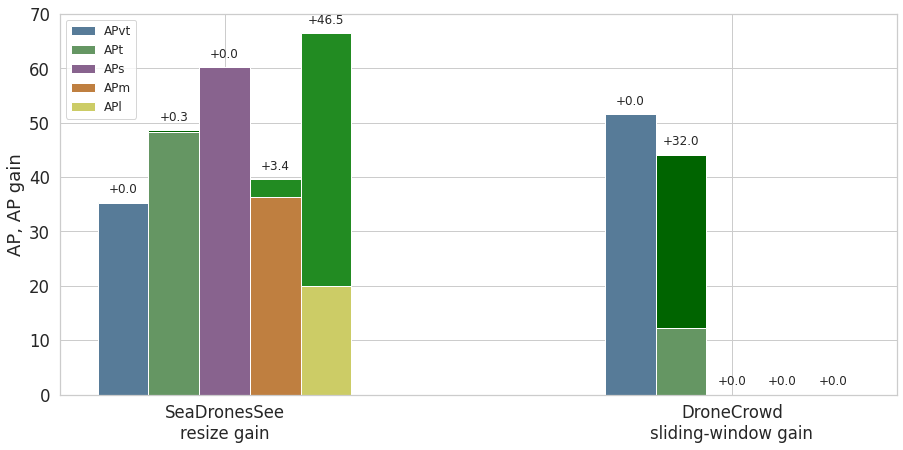

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

datasets = ['SDS', 'DC']
aps = ['APvt', 'APt', 'APs', 'APm', 'APl'] #, 'AP', 'AP50', 'AP75'] #[x for x in diff.columns if 'AP' in x and 'APu' not in x]


sns.set(style = 'whitegrid', font_scale = 1.5)
palette = sns.color_palette("Set1", n_colors=9, desat=0.5)
palette = palette[1:]
sns.set_palette(palette)

# sns.set_palette(sns.color_palette("Set1", desat=0.5))

plt.tight_layout()
plt.figure(figsize=(15,7))
ax  = plt.gca()

N = len(datasets)
ind = np.arange(N)  # the x locations for the groups
width = 0.1  # the width of the bars


rects_base = []
rects_diff = []
for I, ap_name in enumerate(aps):
    roi_values = resize_base[ap_name].values
    roi_track_values = sw[ap_name].values
    diff_values = diff[ap_name].values
    
    bottoms, values, colors, base_values = [], [], [], []
    for d, diff_value in enumerate(diff_values):
        if diff_value < 0:
            bottom = roi_track_values[d]
            value = abs(diff_value)
            color = 'forestgreen'
            base_value = roi_track_values[d]
        else:
            bottom = roi_values[d]
            value = diff_value
            color = 'darkgreen'
            base_value = roi_values[d]
        bottoms.append(bottom); values.append(value); colors.append(color); base_values.append(base_value)

    rect_base = plt.bar(ind+I*width, base_values, width)
    rects_base.append(rect_base)
    
    for i, rect in enumerate(rect_base):
        plt.bar(x = rect.xy[0]+0.5*width, height=values[i], width=width, bottom=bottoms[i], color=colors[i], alpha=1) #0.8)
        
        x = rect.xy[0]+0.5*width
        y = bottoms[i]+abs(diff_values[i]) + 2
        text = f'+{abs(diff_values[i]):.1f}'
        ax.annotate(text, (x,y), ha='center',
                va='center',
                xytext=(0, 2),
                textcoords='offset points', fontsize=12)

# plt.xlabel('model input size')
plt.ylabel('AP, AP gain')
plt.ylim([0,70])

plt.xticks(ind + 2*width, ['SeaDronesSee\nresize gain', 'DroneCrowd\nsliding-window gain'], rotation=0)
_ = plt.legend( [rect[0] for rect in rects_base], aps, loc='upper left', fontsize=12)
plt.savefig('../../plots/ROI-resize-vs-sw.png',bbox_inches='tight', pad_inches=0)
plt.savefig('../../plots/ROI-resize-vs-sw.eps',bbox_inches='tight', pad_inches=0)

## OBS iou_ths

### SDS 

In [5]:
sds_obs = sorted(glob('/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/**/results-test_dev.json', recursive=True))
print(sds_obs)
sds_csv = 'ablation/SDS-OBS-iouths.csv'

# metrics_obs_sds = get_metrics_df(sds_obs, sds_gt, iou_th_sds, max_dets_sds, names_sds, conf=0.1, iou_thres=0.5)
# metrics_obs_sds.to_csv(sds_csv, index=False)
# metrics_obs_sds

metrics_obs_sds = pd.read_csv(sds_csv)
metrics_obs_sds

['/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/SDS-NMS-th01/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/SDS-NMS-th02/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/SDS-NMS-th03/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/SDS-NMS-th04/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/SDS-NMS-th05/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/SDS-NMS-th06/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/SDS-NMS-th07/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/SDS-NMS-th08/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/SDS-NMS-th09/results-test_dev.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/SDS-NONE/results-test_dev.json', '/h

,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,OBS-iou,SDS-NMS-th01,43.362590,80.067881,41.994959,-100,34.957785,40.743679,48.055592,32.883944,...,54.603176,58.745470,38.787450,63.175095,40395,9233,7283,81.395583,84.724611,83.026740
1,OBS-iou,SDS-NMS-th02,46.061499,82.233822,45.406203,-100,34.962112,42.261604,52.120003,34.532247,...,55.445705,61.928124,40.156110,65.999523,41402,9501,6276,81.335088,86.836696,83.995902
2,OBS-iou,SDS-NMS-th03,47.852204,83.531324,48.081494,-100,34.959422,43.455737,54.780521,35.830765,...,56.135744,63.856137,41.121605,67.049141,41840,10158,5838,80.464633,87.755359,83.952004
3,OBS-iou,SDS-NMS-th04,48.736121,83.495236,49.795760,-100,35.090962,43.803614,56.148922,37.395687,...,56.842434,64.954609,42.644232,67.278149,41954,11209,5724,78.915787,87.994463,83.208219
4,OBS-iou,SDS-NMS-th05,49.183813,82.893829,51.328233,-100,35.195857,43.658885,57.056864,38.016136,...,57.519978,65.927469,43.623161,67.259065,42020,12465,5658,77.122144,88.132891,82.260701
5,OBS-iou,SDS-NMS-th06,49.145484,82.291965,51.938304,-100,35.143302,43.079302,57.277838,38.624545,...,58.377459,66.679498,44.430184,67.239981,42056,13819,5622,75.268009,88.208398,81.226039
6,OBS-iou,SDS-NMS-th07,48.669346,80.854823,51.861206,-100,34.919741,41.818846,57.292825,38.908458,...,59.313996,67.352088,45.164767,67.354485,42128,15441,5550,73.178273,88.359411,80.055489
7,OBS-iou,SDS-NMS-th08,48.034369,79.459430,51.084466,-100,34.775032,40.926162,56.784544,39.032094,...,60.053867,68.000604,45.692007,67.468989,42173,17400,5505,70.792137,88.453794,78.643556
8,OBS-iou,SDS-NMS-th09,47.079604,77.431771,50.053602,-100,34.324574,39.142794,55.663979,39.211368,...,60.669129,68.288855,46.181136,67.602576,42221,20345,5457,67.482339,88.554470,76.595552
9,OBS-iou,SDS-NONE,44.623804,72.842434,47.656876,-100,31.476296,35.761931,54.087458,39.183562,...,61.043541,68.367961,46.272568,67.659828,42387,25318,5291,62.605421,88.902639,73.471829


In [57]:
m = []

gt_objects, unique_ids, nc = get_gt(sds_gt)
for det_path in sds_obs:
    method, ds = os.path.dirname(det_path).split(os.sep)[-2:]
    tp,fp,fn,p,r,f1 = get_stats(gt_objects, unique_ids, nc, det_path, conf=0.1, iou_thres=0.5, agnostic=False)
    m.append({
        'method': method,
        'ds': ds,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'P': p*100,
        'R': r*100,
        'F1': f1*100
    })
    
metrics_cls = pd.DataFrame(m)
metrics_cls.to_csv('ablation/SDS-OBS-iouths-basic-classes.csv')
metrics_cls

,method,ds,TP,FP,FN,P,R,F1
0,OBS-iou,SDS-NMS-th01,40395.0,9233.0,7283.0,81.395583,84.724611,83.026740
1,OBS-iou,SDS-NMS-th02,41402.0,9501.0,6276.0,81.335088,86.836696,83.995902
2,OBS-iou,SDS-NMS-th03,41840.0,10158.0,5838.0,80.464633,87.755359,83.952004
3,OBS-iou,SDS-NMS-th04,41954.0,11209.0,5724.0,78.915787,87.994463,83.208219
4,OBS-iou,SDS-NMS-th05,42020.0,12465.0,5658.0,77.122144,88.132891,82.260701
5,OBS-iou,SDS-NMS-th06,42056.0,13819.0,5622.0,75.268009,88.208398,81.226039
6,OBS-iou,SDS-NMS-th07,42128.0,15441.0,5550.0,73.178273,88.359411,80.055489
7,OBS-iou,SDS-NMS-th08,42173.0,17400.0,5505.0,70.792137,88.453794,78.643556
8,OBS-iou,SDS-NMS-th09,42221.0,20345.0,5457.0,67.482339,88.554470,76.595552
9,OBS-iou,SDS-NONE,42387.0,25318.0,5291.0,62.605421,88.902639,73.471829


In [8]:
# m = []
# for det_path in sds_obs:
#     method, ds = os.path.dirname(det_path).split(os.sep)[-2:]
#     tp,fp,fn,p,r,f1 = get_stats(sds_gt, det_path, conf=0.1, iou_thres=0.5, agnostic=True)
#     m.append({
#         'method': method,
#         'ds': ds,
#         'TP': tp,
#         'FP': fp,
#         'FN': fn,
#         'P': p*100,
#         'R': r*100,
#         'F1': f1*100
#     })
    
# metrics_agn = pd.DataFrame(m)
# metrics_agn.to_csv('ablation/SDS-OBS-iouths-basic-agnostic.csv')
# metrics_agn

### DC

In [208]:
dc_obs = glob('/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/**/results-test_minus_val.json', recursive=True)
dc_csv = 'ablation/DC-OBS-iouths.csv'

In [ ]:
# m = []

# gt_objects, unique_ids, nc = get_gt(dc_gt, agnostic=False)
# for det_path in tqdm(dc_obs):
#     method, ds = os.path.dirname(det_path).split(os.sep)[-2:]
#     tp,fp,fn,p,r,f1 = get_stats(gt_objects, unique_ids, nc, det_path, conf=0.1, iou_thres=0.5, agnostic=False)
#     m.append({
#         'method': method,
#         'ds': ds,
#         'TP': tp,
#         'FP': fp,
#         'FN': fn,
#         'P': p*100,
#         'R': r*100,
#         'F1': f1*100
#     })
    
# metrics_cls = pd.DataFrame(m)
# metrics_cls.to_csv('ablation/DC-OBS-iouths-basic-classes.csv')
# metrics_cls

In [12]:
metrics_obs_dc = get_metrics_df(dc_obs, dc_gt, iou_th_dc, max_dets_dc, names_dc)
metrics_obs_dc.to_csv(dc_csv, index=False)
metrics_obs_dc

  0%|                                                                                                                                           | 0/2 [00:45<?, ?it/s]

KeyboardInterrupt



### MTSD

In [205]:
# mtsd_obs = sorted(glob('/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/MTSD*/results-val.json', recursive=True))
# mtsd_gt = 'data/MTSD/val.json'
# print(mtsd_obs)
# mtsd_csv = 'ablation/MTSD-OBS-iouths.csv'

# gt_objects, unique_ids, nc = get_gt(mtsd_gt, agnostic=False)
# m = []
# for det_path in tqdm(mtsd_obs):
#     method, ds = os.path.dirname(det_path).split(os.sep)[-2:]
#     tp,fp,fn,p,r,f1 = get_stats(gt_objects, unique_ids, nc, det_path, conf=0.1, iou_thres=0.5, agnostic=False)
#     m.append({
#         'method': method,
#         'ds': ds,
#         'TP': tp,
#         'FP': fp,
#         'FN': fn,
#         'P': p*100,
#         'R': r*100,
#         'F1': f1*100
#     })
    
metrics_cls = pd.DataFrame(m)
metrics_cls.to_csv('ablation/MTSD-OBS-iouths-basic-classes.csv')
metrics_cls

,method,ds,TP,FP,FN,P,R,F1
0,OBS-iou,MTSD-OBS-disabled,14907.0,21913.0,11194.0,40.486149,57.112754,47.383227
1,OBS-iou,MTSD-OBS-th01,14989.0,17300.0,11112.0,46.421382,57.426919,51.340983
2,OBS-iou,MTSD-OBS-th02,15050.0,17411.0,11051.0,46.363328,57.660626,51.398518
3,OBS-iou,MTSD-OBS-th03,15068.0,17570.0,11033.0,46.167045,57.729589,51.304925
4,OBS-iou,MTSD-OBS-th04,15045.0,17742.0,11056.0,45.887089,57.641470,51.096998
5,OBS-iou,MTSD-OBS-th05,15018.0,17894.0,11083.0,45.630773,57.538025,50.897260
6,OBS-iou,MTSD-OBS-th06,14988.0,17998.0,11113.0,45.437458,57.423087,50.731971
7,OBS-iou,MTSD-OBS-th07,14956.0,18143.0,11145.0,45.185655,57.300487,50.527027
8,OBS-iou,MTSD-OBS-th08,14924.0,18355.0,11177.0,44.845098,57.177886,50.266083
9,OBS-iou,MTSD-OBS-th09,14858.0,18489.0,11243.0,44.555732,56.925022,49.986543


In [207]:
metrics_obs_mtsd = get_metrics_df(mtsd_obs, mtsd_gt, iou_th_sds, max_dets_sds, names_sds)
metrics_obs_mtsd.to_csv(mtsd_csv, index=False)
metrics_obs_mtsd

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [29:48<00:00, 178.88s/it]


,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,OBS-iou,MTSD-OBS-disabled,44.262501,74.401721,48.142753,16.298783,43.203314,51.480221,51.278952,39.920868,...,57.937577,57.570502,46.538440,34.992308,14907.0,21913.0,11194.0,40.486149,57.112754,47.383227
1,OBS-iou,MTSD-OBS-th01,42.718442,71.770968,46.330620,14.345808,41.776499,50.242186,49.476017,38.239507,...,56.112338,54.922059,43.687226,34.730769,14989.0,17300.0,11112.0,46.421382,57.426919,51.340983
2,OBS-iou,MTSD-OBS-th02,42.847899,71.985319,46.507488,14.345928,41.876279,50.356826,49.580935,38.400044,...,56.235746,55.025568,43.986120,34.730769,15050.0,17411.0,11051.0,46.363328,57.660626,51.398518
3,OBS-iou,MTSD-OBS-th03,42.872981,72.048234,46.526880,14.345757,41.943007,50.301694,49.611503,38.315762,...,56.193646,55.080884,44.032594,34.730769,15068.0,17570.0,11033.0,46.167045,57.729589,51.304925
4,OBS-iou,MTSD-OBS-th04,42.723714,71.739625,46.406556,16.449262,41.811569,49.983676,49.494477,38.323986,...,55.950158,54.979398,44.033696,34.730769,15045.0,17742.0,11056.0,45.887089,57.641470,51.096998
5,OBS-iou,MTSD-OBS-th05,42.770917,71.784570,46.512984,16.445277,41.768073,50.007041,49.585131,38.236359,...,55.954628,55.184042,44.112221,34.730769,15018.0,17894.0,11083.0,45.630773,57.538025,50.897260
6,OBS-iou,MTSD-OBS-th06,42.710897,71.642320,46.483742,16.444465,41.679319,49.864316,49.563581,38.235347,...,55.792945,55.183361,44.112372,34.730769,14988.0,17998.0,11113.0,45.437458,57.423087,50.731971
7,OBS-iou,MTSD-OBS-th07,42.616131,71.448448,46.436159,16.443993,41.508969,49.740137,49.536794,38.123441,...,55.689830,55.174625,43.983930,34.730769,14956.0,18143.0,11145.0,45.185655,57.300487,50.527027
8,OBS-iou,MTSD-OBS-th08,42.486597,71.280624,46.243302,16.443737,41.377076,49.613103,49.486626,38.123155,...,55.609740,55.142167,43.983930,34.884615,14924.0,18355.0,11177.0,44.845098,57.177886,50.266083
9,OBS-iou,MTSD-OBS-th09,42.282414,70.908459,46.022403,12.759582,41.241831,49.426651,49.156676,38.066901,...,55.377593,54.803458,43.944868,34.961538,14858.0,18489.0,11243.0,44.555732,56.925022,49.986543


### Zebra

In [138]:
zebra_obs = sorted(glob('/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/**/results-val.json', recursive=True))
zebra_obs = [x for x in zebra_obs if 'Zebra' in x and 'vis' not in x]
print(zebra_obs, len(zebra_obs))
zebra_obs = [x for x in zebra_obs if 'no_dil' in x]
print(zebra_obs, len(zebra_obs))
zebra_csv = 'ablation/Zebra-OBS-iouths.csv'
zebra_gt = 'data/3DZeF20/val.json'

gt_objects, unique_ids, nc = get_gt(zebra_gt, agnostic=False)

m = []
for det_path in tqdm(zebra_obs):
    method, ds = os.path.dirname(det_path).split(os.sep)[-2:]
    method = ds.split('-')[1]
    _th = ds.split('-')[-1].replace('th0', '0.')
    tp,fp,fn,p,r,f1 = get_stats(gt_objects, unique_ids, nc, det_path, conf=0.1, iou_thres=0.5, agnostic=False)
    m.append({
        'method': method,
        'iou_th': _th,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'P': p*100,
        'R': r*100,
        'F1': f1*100
    })
    
metrics_cls = pd.DataFrame(m)
metrics_cls.to_csv('ablation/Zebra-OBS-iouths-basic-classes.csv')
metrics_cls

['/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/Zebra-NMS-th01/results-val.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/Zebra-NMS-th02/results-val.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/Zebra-NMS-th03/results-val.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/Zebra-NMS-th04/results-val.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/Zebra-NMS-th05/results-val.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/Zebra-NMS-th06/results-val.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/Zebra-NMS-th07/results-val.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/Zebra-NMS-th08/results-val.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/Zebra-NMS-th09/results-val.json', '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/Zebra-NMS_no_dil-th01/results-val.json', '/home/kos/projects/Ph

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [05:05<00:00, 16.98s/it]


,method,iou_th,TP,FP,FN,P,R,F1
0,NMS_no_dil,0.1,12334.0,3931.0,3908.0,75.831540,75.938924,75.885194
1,NMS_no_dil,0.2,14346.0,4272.0,1896.0,77.054463,88.326561,82.306368
2,NMS_no_dil,0.3,15169.0,5305.0,1073.0,74.089089,93.393671,82.628827
3,NMS_no_dil,0.4,15384.0,6589.0,858.0,70.013198,94.717399,80.512888
4,NMS_no_dil,0.5,15477.0,7877.0,765.0,66.271303,95.289989,78.174563
5,NMS_no_dil,0.6,15531.0,8940.0,711.0,63.466961,95.622460,76.295041
6,NMS_no_dil,0.7,15546.0,9847.0,696.0,61.221597,95.714813,74.677555
7,NMS_no_dil,0.8,15550.0,10547.0,692.0,59.585393,95.739441,73.454734
8,NMS_no_dil,0.9,15554.0,10899.0,688.0,58.798624,95.764068,72.860991
9,OBS_no_NMS_no_dil,0.1,14688.0,2196.0,1554.0,86.993603,90.432213,88.679587


In [144]:
zebra_obs = sorted(glob('/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/**/results-val.json', recursive=True))
zebra_obs = [x for x in zebra_obs if 'Zebra' in x and 'NONE_no_dil' in x]
zebra_obs

['/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/Zebra-NONE_no_dil/results-val.json']

In [145]:
no_dil_none = get_metrics_df(zebra_obs, zebra_gt, iou_th_sds, max_dets_sds, names_sds)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:13<00:00, 73.75s/it]


In [146]:
metrics_obs_zebra = pd.concat([metrics_obs_zebra, no_dil_none], ignore_index=True)
metrics_obs_zebra

,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,OBS-iou,Zebra-NMS_no_dil-th01,37.371401,65.631028,35.448692,-100.0,0.0,14.146681,33.840260,42.680092,...,29.240506,55.703831,52.327452,-100.0,12334.0,3931.0,3908.0,75.831540,75.938924,75.885194
1,OBS-iou,Zebra-NMS_no_dil-th02,50.049119,84.678815,47.761964,-100.0,0.0,14.724015,47.281984,53.906004,...,36.177215,63.980560,63.442484,-100.0,14346.0,4272.0,1896.0,77.054463,88.326561,82.306368
2,OBS-iou,Zebra-NMS_no_dil-th03,59.475237,91.316508,59.710614,-100.0,0.0,15.152106,56.959015,63.544127,...,41.696203,69.749571,71.878617,-100.0,15169.0,5305.0,1073.0,74.089089,93.393671,82.628827
3,OBS-iou,Zebra-NMS_no_dil-th04,64.624071,91.535893,69.085340,-100.0,0.0,16.048843,61.740011,69.303293,...,45.265823,73.037164,76.709951,-100.0,15384.0,6589.0,858.0,70.013198,94.717399,80.512888
4,OBS-iou,Zebra-NMS_no_dil-th05,67.315844,91.197454,76.253495,-100.0,0.0,15.414978,64.165927,72.255976,...,48.253165,75.073756,79.453776,-100.0,15477.0,7877.0,765.0,66.271303,95.289989,78.174563
5,OBS-iou,Zebra-NMS_no_dil-th06,68.200035,90.534452,78.512877,-100.0,0.0,15.219674,65.093484,72.942307,...,51.468354,76.401372,80.379675,-100.0,15531.0,8940.0,711.0,63.466961,95.622460,76.295041
6,OBS-iou,Zebra-NMS_no_dil-th07,68.247897,90.076913,78.240041,-100.0,0.0,15.150011,65.488675,72.891622,...,52.430380,77.020011,80.605505,-100.0,15546.0,9847.0,696.0,61.221597,95.714813,74.677555
7,OBS-iou,Zebra-NMS_no_dil-th08,68.329756,89.833288,78.500887,-100.0,0.0,14.978804,65.429402,72.913324,...,53.240506,77.308176,80.708539,-100.0,15550.0,10547.0,692.0,59.585393,95.739441,73.454734
8,OBS-iou,Zebra-NMS_no_dil-th09,68.353104,90.227554,78.523039,-100.0,0.0,14.907826,65.436790,73.066303,...,53.620253,77.419097,80.738179,-100.0,15554.0,10899.0,688.0,58.798624,95.764068,72.860991
9,OBS-iou,Zebra-OBS_no_NMS_no_dil-th01,68.364507,89.478039,78.322487,-100.0,0.0,29.278119,67.427328,71.392762,...,48.025316,73.129788,77.091037,-100.0,14688.0,2196.0,1554.0,86.993603,90.432213,88.679587


In [147]:
metrics_obs_zebra.to_csv(zebra_csv, index=False)

In [139]:
metrics_obs_zebra = get_metrics_df(zebra_obs, zebra_gt, iou_th_sds, max_dets_sds, names_sds)
metrics_obs_zebra.to_csv(zebra_csv, index=False)
metrics_obs_zebra

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [14:34<00:00, 48.60s/it]


,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,OBS-iou,Zebra-NMS_no_dil-th01,37.371401,65.631028,35.448692,-100.0,0.0,14.146681,33.840260,42.680092,...,29.240506,55.703831,52.327452,-100.0,12334.0,3931.0,3908.0,75.831540,75.938924,75.885194
1,OBS-iou,Zebra-NMS_no_dil-th02,50.049119,84.678815,47.761964,-100.0,0.0,14.724015,47.281984,53.906004,...,36.177215,63.980560,63.442484,-100.0,14346.0,4272.0,1896.0,77.054463,88.326561,82.306368
2,OBS-iou,Zebra-NMS_no_dil-th03,59.475237,91.316508,59.710614,-100.0,0.0,15.152106,56.959015,63.544127,...,41.696203,69.749571,71.878617,-100.0,15169.0,5305.0,1073.0,74.089089,93.393671,82.628827
3,OBS-iou,Zebra-NMS_no_dil-th04,64.624071,91.535893,69.085340,-100.0,0.0,16.048843,61.740011,69.303293,...,45.265823,73.037164,76.709951,-100.0,15384.0,6589.0,858.0,70.013198,94.717399,80.512888
4,OBS-iou,Zebra-NMS_no_dil-th05,67.315844,91.197454,76.253495,-100.0,0.0,15.414978,64.165927,72.255976,...,48.253165,75.073756,79.453776,-100.0,15477.0,7877.0,765.0,66.271303,95.289989,78.174563
5,OBS-iou,Zebra-NMS_no_dil-th06,68.200035,90.534452,78.512877,-100.0,0.0,15.219674,65.093484,72.942307,...,51.468354,76.401372,80.379675,-100.0,15531.0,8940.0,711.0,63.466961,95.622460,76.295041
6,OBS-iou,Zebra-NMS_no_dil-th07,68.247897,90.076913,78.240041,-100.0,0.0,15.150011,65.488675,72.891622,...,52.430380,77.020011,80.605505,-100.0,15546.0,9847.0,696.0,61.221597,95.714813,74.677555
7,OBS-iou,Zebra-NMS_no_dil-th08,68.329756,89.833288,78.500887,-100.0,0.0,14.978804,65.429402,72.913324,...,53.240506,77.308176,80.708539,-100.0,15550.0,10547.0,692.0,59.585393,95.739441,73.454734
8,OBS-iou,Zebra-NMS_no_dil-th09,68.353104,90.227554,78.523039,-100.0,0.0,14.907826,65.436790,73.066303,...,53.620253,77.419097,80.738179,-100.0,15554.0,10899.0,688.0,58.798624,95.764068,72.860991
9,OBS-iou,Zebra-OBS_no_NMS_no_dil-th01,68.364507,89.478039,78.322487,-100.0,0.0,29.278119,67.427328,71.392762,...,48.025316,73.129788,77.091037,-100.0,14688.0,2196.0,1554.0,86.993603,90.432213,88.679587


## SEG - SAM vs BBOXES

In [29]:
sds = sorted(glob('/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/SAM-vs-BBOXES/**/results-test_dev.json', recursive=True))
print(len(sds))
sds_csv = 'ablation/SDS-SEG-SAM-vs-BBOXES.csv'


# m = []

# gt_objects, unique_ids, nc = get_gt(sds_gt, agnostic=False)
# for det_path in tqdm(sds):
#     method, ds = os.path.dirname(det_path).split(os.sep)[-2:]
#     tp,fp,fn,p,r,f1 = get_stats(gt_objects, unique_ids, nc, det_path, conf=0.1, iou_thres=0.5, agnostic=False)
#     m.append({
#         'method': method,
#         'ds': ds,
#         'TP': tp,
#         'FP': fp,
#         'FN': fn,
#         'P': p*100,
#         'R': r*100,
#         'F1': f1*100
#     })
    
# metrics = pd.DataFrame(m)
# metrics.to_csv('ablation/SDS-SEG-SAM-vs-BBOXES-simple.csv')
# metrics

6


In [30]:
metrics = get_metrics_df(sds, sds_gt, iou_th_sds, max_dets_sds, names_sds, conf=0.1, iou_thres=0.5)
metrics.to_csv(sds_csv, index=False)
metrics

100%|████████████████████████████████████████████████████████████████| 6/6 [16:39<00:00, 166.56s/it]


,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,SAM-vs-BBOXES,SDS-bboxes0,51.316923,83.008487,55.258205,-100.0,34.715740,48.590300,60.870707,38.838916,...,59.246341,68.117067,45.794839,67.062659,42072.0,11683.0,5606.0,78.266208,88.241956,82.955251
1,SAM-vs-BBOXES,SDS-bboxes1,51.424400,83.839138,54.984125,-100.0,35.722225,48.040617,60.200531,39.484210,...,59.690860,68.232501,46.268207,67.659828,42349.0,11088.0,5329.0,79.250332,88.822937,83.764031
2,SAM-vs-BBOXES,SDS-bboxes2,51.758411,84.100175,55.502879,-100.0,35.594475,49.086101,60.159082,38.944869,...,60.569799,68.202023,45.691534,64.074030,42499.0,11067.0,5179.0,79.339506,89.137548,83.953617
3,SAM-vs-BBOXES,SDS-masks0,50.666052,82.165270,54.794824,-100.0,34.527086,47.396839,60.299802,37.369324,...,59.042768,68.098281,45.825188,57.035027,41874.0,11989.0,5804.0,77.741678,87.826671,82.477029
4,SAM-vs-BBOXES,SDS-masks1,51.200768,83.705396,55.007828,-100.0,36.316321,48.869813,60.099526,37.836593,...,60.836983,68.365436,46.129149,63.625954,42388.0,13254.0,5290.0,76.179864,88.904736,82.051878
5,SAM-vs-BBOXES,SDS-masks2,51.246706,83.501455,55.349808,-100.0,36.005314,48.597148,60.411605,36.307285,...,60.877413,68.342208,45.182379,59.241810,42369.0,14462.0,5309.0,74.552621,88.864885,81.082012


## SDS models

In [16]:
sds = sorted(glob('/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/compare-SDS/**/results-test_dev.json', recursive=True))
sds_csv = 'ablation/SDS-yolo-models.csv'

metrics_sds_models = get_metrics_df(sds, sds_gt, iou_th_sds, max_dets_sds, names_sds, conf=0.1, iou_thres=0.5)
metrics_sds_models.to_csv(sds_csv, index=False)
metrics_sds_models

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [20:26<00:00, 245.30s/it]


,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,compare-SDS,004-tiny-100ep-best,51.160605,83.933229,54.988920,-100.0,35.182659,48.285822,60.097395,38.799307,...,59.789171,68.415319,45.488172,67.059677,42412.0,11512.0,5266.0,78.651435,88.955074,83.486546
1,compare-SDS,004-tiny-100ep-last,51.424400,83.839138,54.984125,-100.0,35.722225,48.040617,60.200531,39.484210,...,59.690860,68.232501,46.268207,67.659828,42349.0,11088.0,5329.0,79.250332,88.822937,83.764031
2,compare-SDS,005-v7,51.725204,84.402441,54.818483,-100.0,32.645801,49.761630,60.181680,41.132546,...,60.994954,68.173954,47.941232,75.076336,42340.0,11892.0,5338.0,78.071987,88.804061,83.092925
3,compare-SDS,006-tiny-300ep,52.746991,84.747987,57.266248,-100.0,34.561255,51.217965,61.823655,37.738806,...,61.980708,70.000509,44.471645,72.508548,42782.0,12755.0,4896.0,77.033329,89.731113,82.898803
4,compare-SDS,007-tiny-100ep-bigger,51.677264,84.357516,55.701838,-100.0,35.618115,47.856213,61.395898,39.053268,...,59.464247,69.712267,45.215177,68.692351,42641.0,11586.0,5037.0,78.634260,89.435379,83.687748
